In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
# Import helpers.py from the assets folder - specific for this data
from assets import helpers

# Let's explore the data acquired with the user AB81:

In [2]:
df = pd.read_csv("data/AB81_ml_dataset_extracted.csv", index_col=0)

In [3]:
df.head()

,time,JointPositions_1,JointPositions_2,JointPositions_3,JointPositions_4,JointVelocities_1,JointVelocities_2,JointVelocities_3,JointVelocities_4,JointTorques_1,...,AnklePositionDesired_1,AnklePositionDesired_2,condition,condition_encoded,step_number_l,step_complete_l,step_number_r,step_complete_r,gait_cycle_left,gait_cycle_right
0,1419.713194,0.229033,-0.630698,0.340938,-0.689872,0.075938,0.214246,-0.002334,-0.017197,0.0,...,6.0,0.0,transparent_UNDEFINED,0,0,False,0,False,0,0
1,1419.713578,0.229033,-0.630698,0.340938,-0.689872,0.075938,0.214246,-0.002334,-0.017197,0.0,...,6.0,0.0,transparent_UNDEFINED,0,0,False,0,False,0,0
2,1419.715728,0.229164,-0.630322,0.340932,-0.689934,0.074808,0.216892,-0.002577,-0.020785,0.0,...,6.0,0.0,transparent_UNDEFINED,0,0,False,0,False,0,0
3,1419.716460,0.229352,-0.629734,0.340926,-0.689991,0.070248,0.219566,-0.002004,-0.024639,0.0,...,6.0,0.0,transparent_UNDEFINED,0,0,False,0,False,0,0
4,1419.718743,0.229352,-0.629734,0.340926,-0.689991,0.070248,0.219566,-0.002004,-0.024639,0.0,...,6.0,0.0,transparent_UNDEFINED,0,0,False,0,False,0,0


![DatasetDescription](assets/dataDescriptionGitHub.png)

In [4]:
df.columns

Index(['time', ' JointPositions_1', ' JointPositions_2', ' JointPositions_3',
       ' JointPositions_4', ' JointVelocities_1', ' JointVelocities_2',
       ' JointVelocities_3', ' JointVelocities_4', ' JointTorques_1',
       ' JointTorques_2', ' JointTorques_3', ' JointTorques_4',
       ' DesiredJointTorques_1', ' DesiredJointTorques_2',
       ' DesiredJointTorques_3', ' DesiredJointTorques_4',
       ' JointTorquesViaGauges_1', ' JointTorquesViaGauges_2',
       ' JointTorquesViaGauges_3', ' JointTorquesViaGauges_4',
       ' InteractionForces_1', ' InteractionForces_2', ' InteractionForces_3',
       ' InteractionForces_4', ' InteractionForces_5',
       ' SmoothedInteractionForces_1', ' SmoothedInteractionForces_2',
       ' SmoothedInteractionForces_3', ' SmoothedInteractionForces_4',
       ' SmoothedInteractionForces_5', ' enableRenderingFlag',
       ' DesiredInteractionForces_1', ' DesiredInteractionForces_2',
       ' DesiredInteractionForces_3', ' DesiredInteractionForces

**todo** AnklePositionActual_1 -> clean name

**todo here**; remove not needed columns:  DyadicJointStiffness_1', ' DyadicJointStiffness_2',
       ' DyadicJointStiffness_3', ' DyadicJointStiffness_4',
       ' DyadicJointDamping_1', ' DyadicJointDamping_2',
       ' DyadicJointDamping_3', ' DyadicJointDamping_4',
       ' DyadicJointNeutralAngle_1', ' DyadicJointNeutralAngle_2',
       ' DyadicJointNeutralAngle_3', ' DyadicJointNeutralAngle_4',
       ' DyadicTaskStiffness_1', ' DyadicTaskStiffness_2',
       ' DyadicTaskDamping_1', ' DyadicTaskDamping_2',
       ' DyadicTaskSNeutralAngle_1', ' DyadicTaskSNeutralAngle_2',
       ' AnklePositionActual_1', ' AnklePositionActual_2',
       ' AnklePositionDesired_1', ' AnklePositionDesired_2'

**+todo** add a figure of what joint is what -- also linked with helpers definition

Helpers.py contains certain functions that can help to understand how certain columns are created in the dataset (such as `step_complete_r` for example):
- `check_transition()`: This function encapsulates the logic for identifying transitions, making the code more concise.
- `assign_step_number()`: This function handles the assignment of step numbers using cumsum(), eliminating the need for a global variable and manual incrementing.
-  `check_step_completeness()`: This function checks for step completeness, taking the DataFrame, step number column, and ankle position column as arguments, making it more flexible.
- `process_steps()`: This function serves as the main entry point, orchestrating the step processing pipeline. It takes the DataFrame and relevant column names as arguments, enhancing clarity and adaptability.

# Visualize each stride, and its associated speed

In [5]:
df["StrideLength"] = 0.0

l = [0.4,0.4]
#l = [0.37,0.35]
for step in df.step_number_r.unique():
    th0 = df.loc[df.step_number_r==step,' BackPackAngle']

    # to do : consider only coordinates when foot is in swing ?
    th1 = df.loc[(df.step_number_r==step),' JointPositions_3']
    th2 = df.loc[(df.step_number_r==step),' JointPositions_4']

    xAnkle = -l[0] * np.cos(th0 + th1) - l[1] * np.cos(th0 + th1 + th2)
    yAnkle = -l[0] * np.sin(th0 + th1) - l[1] * np.sin(th0 + th1 + th2)

    #stepLength = np.max(xAnkle) - np.min(xAnkle)
    df.loc[df.step_number_r==step, 'StrideLength'] = (np.max(xAnkle) - np.min(xAnkle)).astype(float)

for step in df.step_number_r.unique():

  df.loc[df.step_number_r==step,"StrideTime"] = df[df.step_number_r==step].time.iloc[-1]-df[df.step_number_r==step].time.iloc[0]

df["StrideSpeed"] = df.StrideLength / df.StrideTime

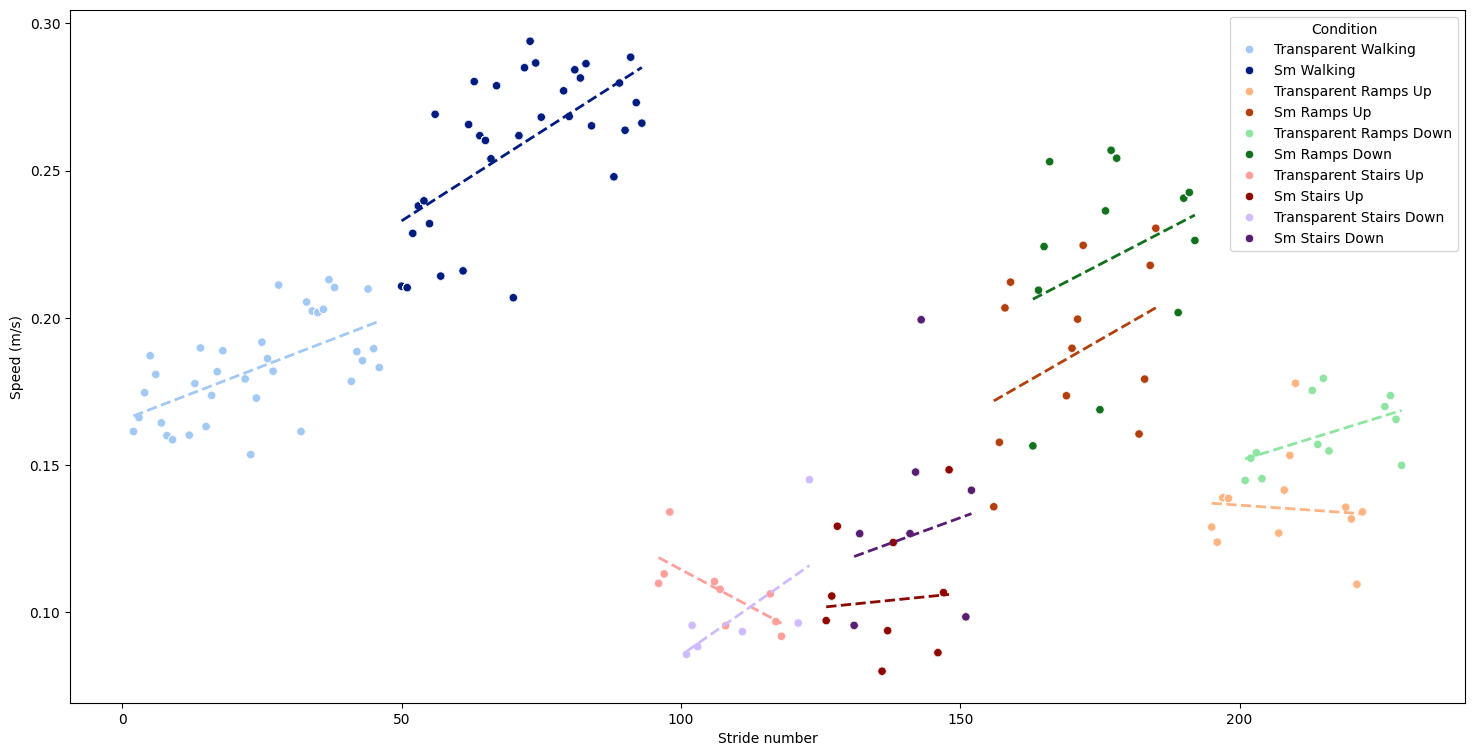

In [6]:
# Filter DataFrame
filtered_df = df[(df['step_complete_r']) & (~df['condition'].str.contains("UNDEFINED"))]

plt.figure(figsize=(18, 9))  # Adjust figure size

# Plot the scatterplot with custom palette
ax = sns.scatterplot(
    data=filtered_df, x="step_number_r", y="StrideSpeed", 
    hue="condition", palette=helpers.custom_palette, hue_order=helpers.order
)

# Calculate and plot linear regression lines for each condition
for i, condition in enumerate(helpers.order):
    data = filtered_df[filtered_df['condition'] == condition]
    X = data['step_number_r'].values.reshape(-1, 1)
    y = data['StrideSpeed'].values
    model = LinearRegression().fit(X, y)
    ax.plot(X, model.predict(X), linestyle='--', linewidth=2, color=helpers.custom_palette[i])

# Modify legend labels
handles, labels = ax.get_legend_handles_labels()
formatted_labels = [helpers.format_activity(label) for label in labels]  # Format labels

# Update legend with formatted labels
ax.legend(handles, formatted_labels, title="Condition")

# Axis labels
plt.ylabel("Speed (m/s)")
plt.xlabel("Stride number")

# Show the plot
plt.show()

# Compute a simple metric: Interaction Power

In [7]:
# compute net power: vel*int.torque
df["NetPower_1"] = df[" JointVelocities_1"]*df[" InteractionForces_2"]
df["NetPower_2"] = df[" JointVelocities_2"]*df[" InteractionForces_3"]
df["NetPower_3"] = df[" JointVelocities_3"]*df[" InteractionForces_4"]
df["NetPower_4"] = df[" JointVelocities_4"]*df[" InteractionForces_5"]

# Visualize the dataset (similar as Figure A2):

SM_WALKING


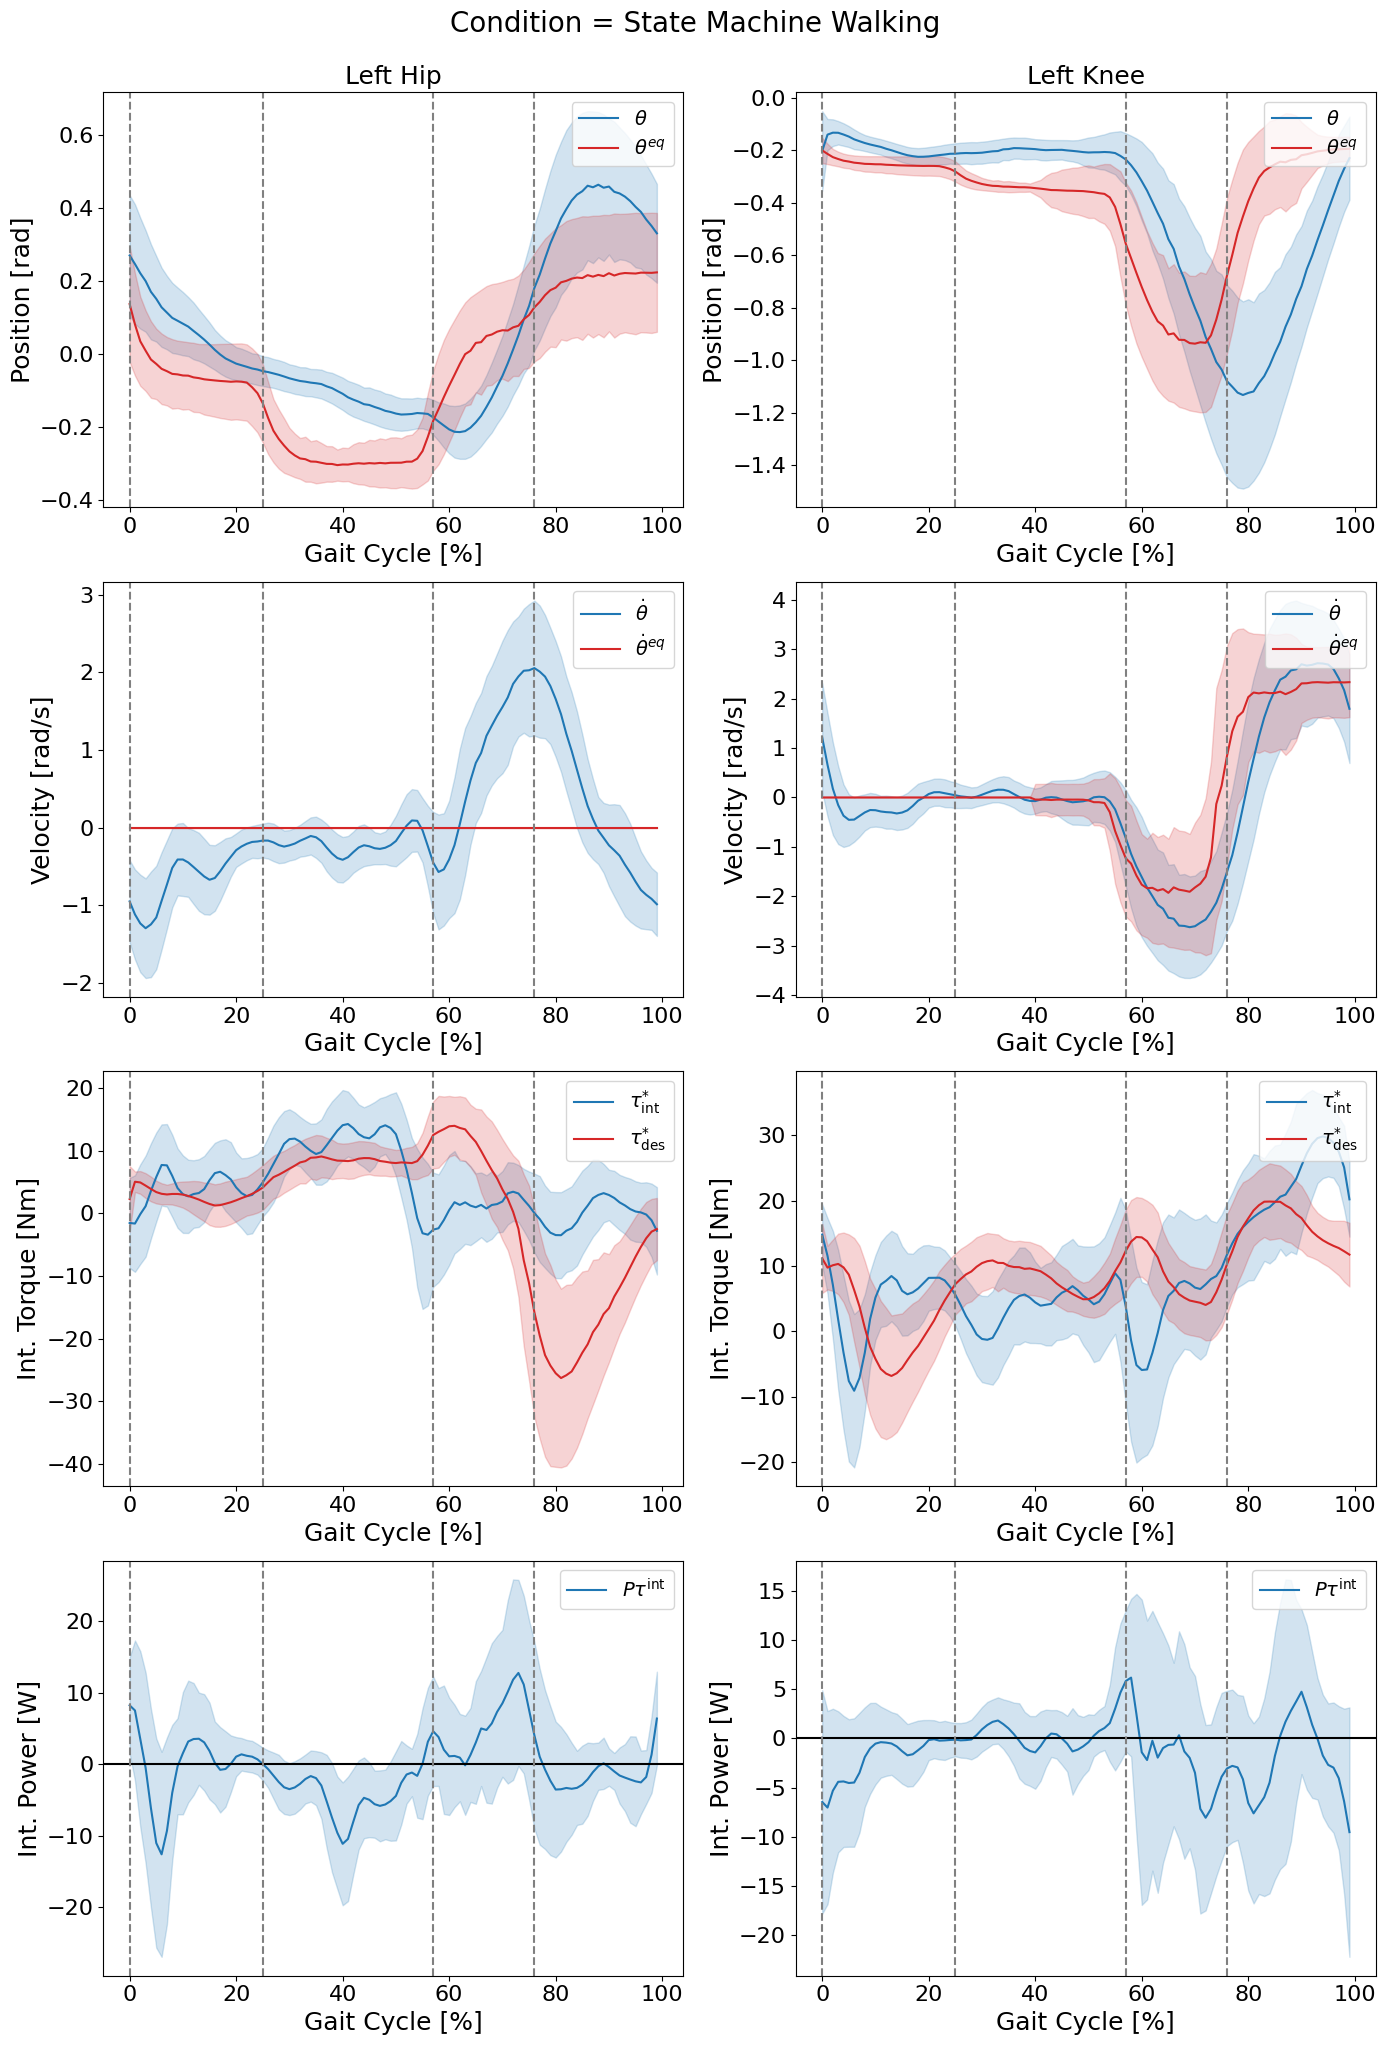

SM_STAIRS_UP


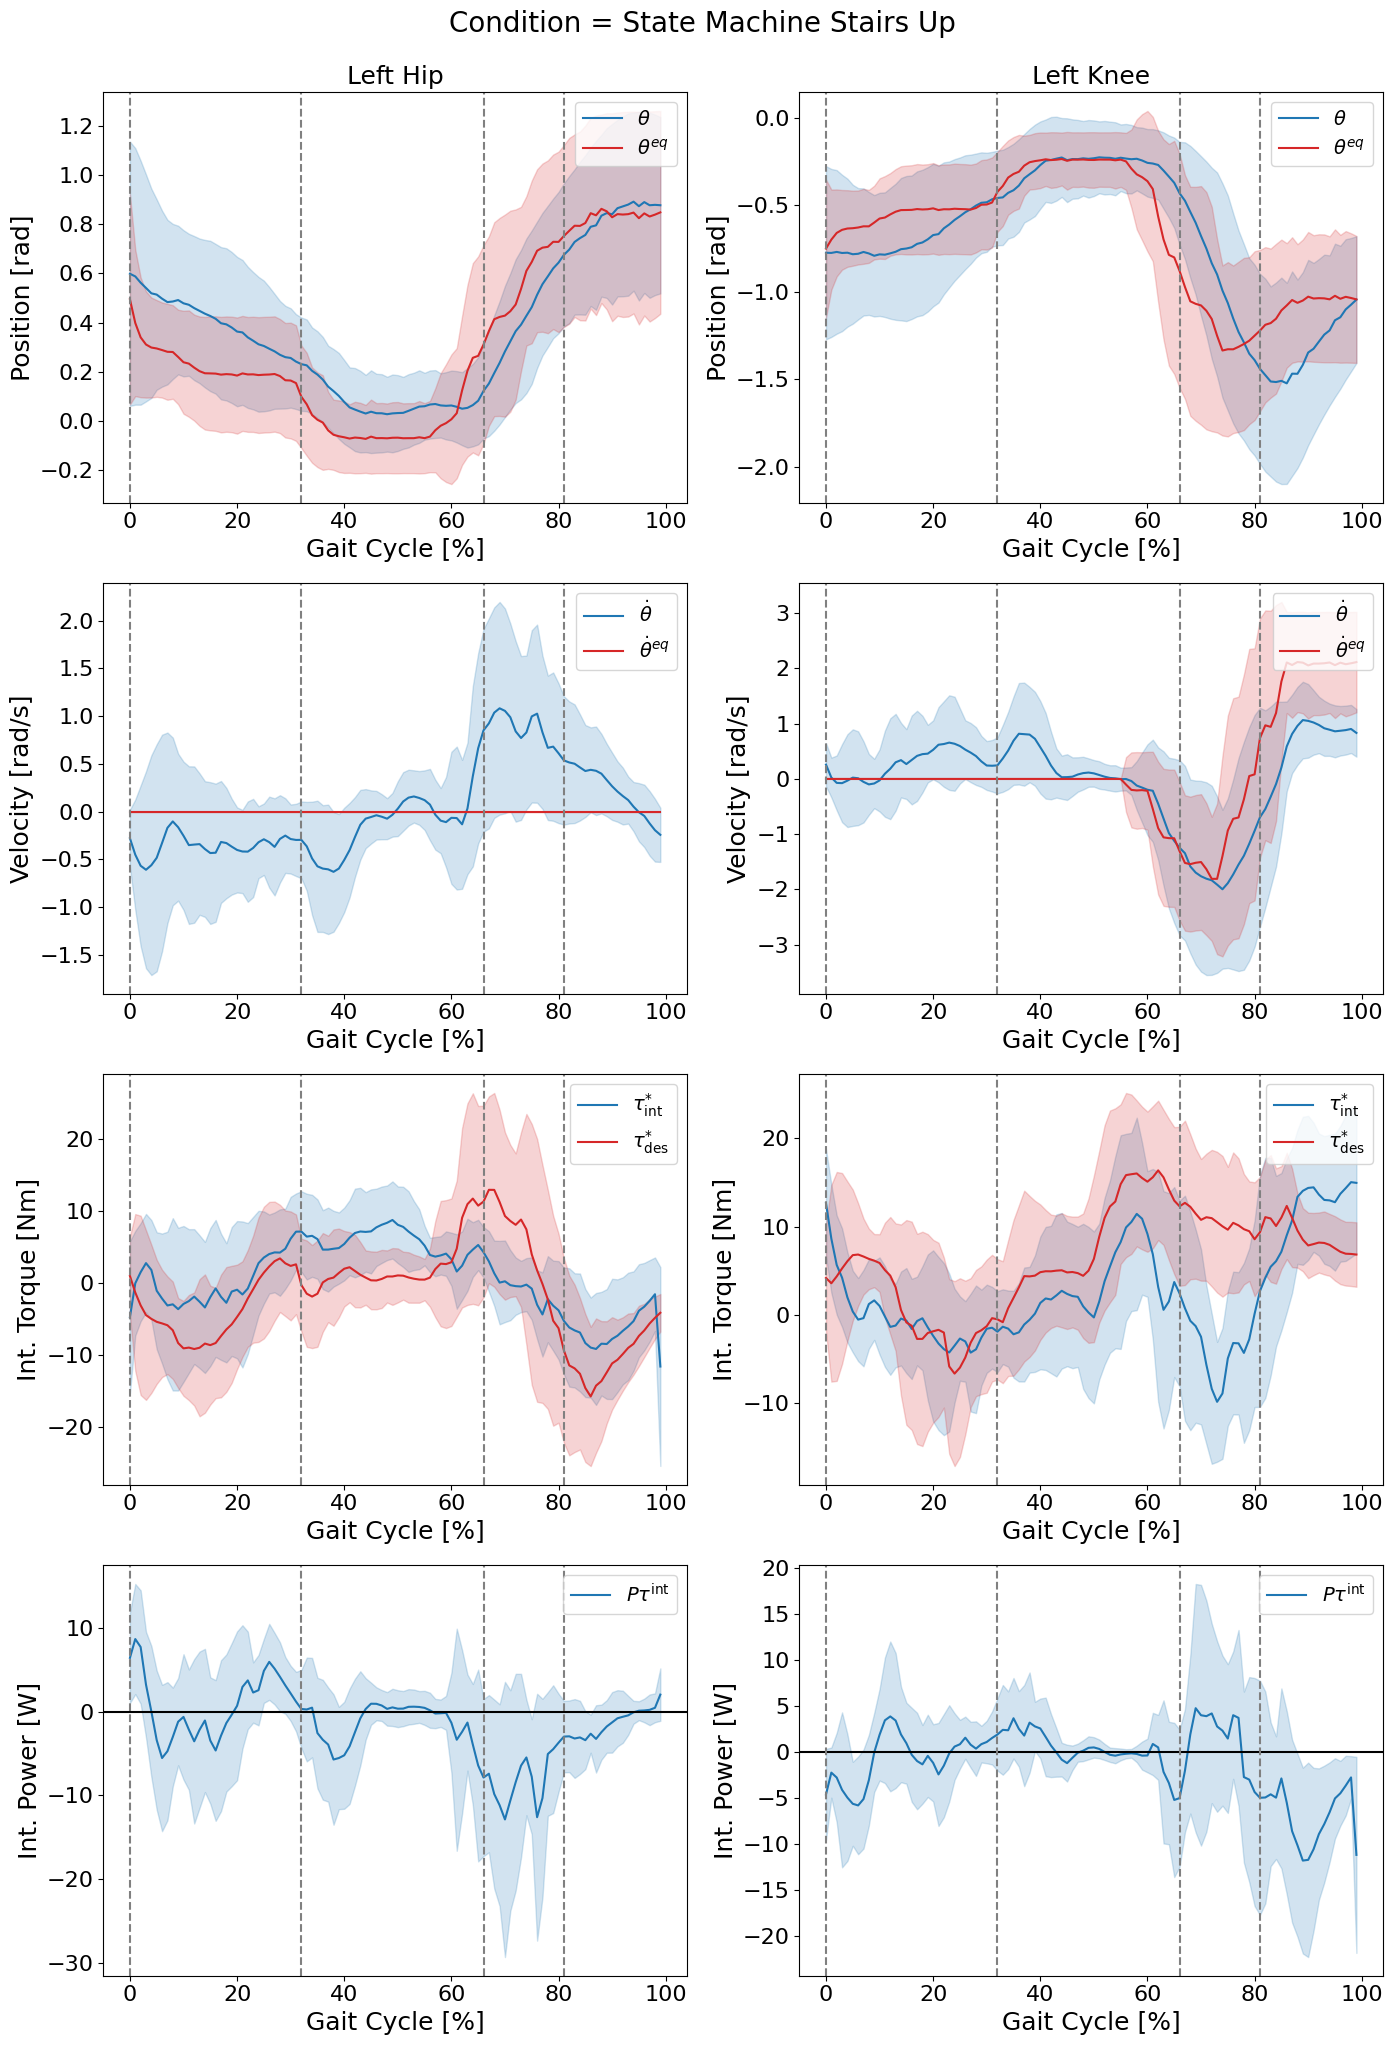

SM_STAIRS_DOWN


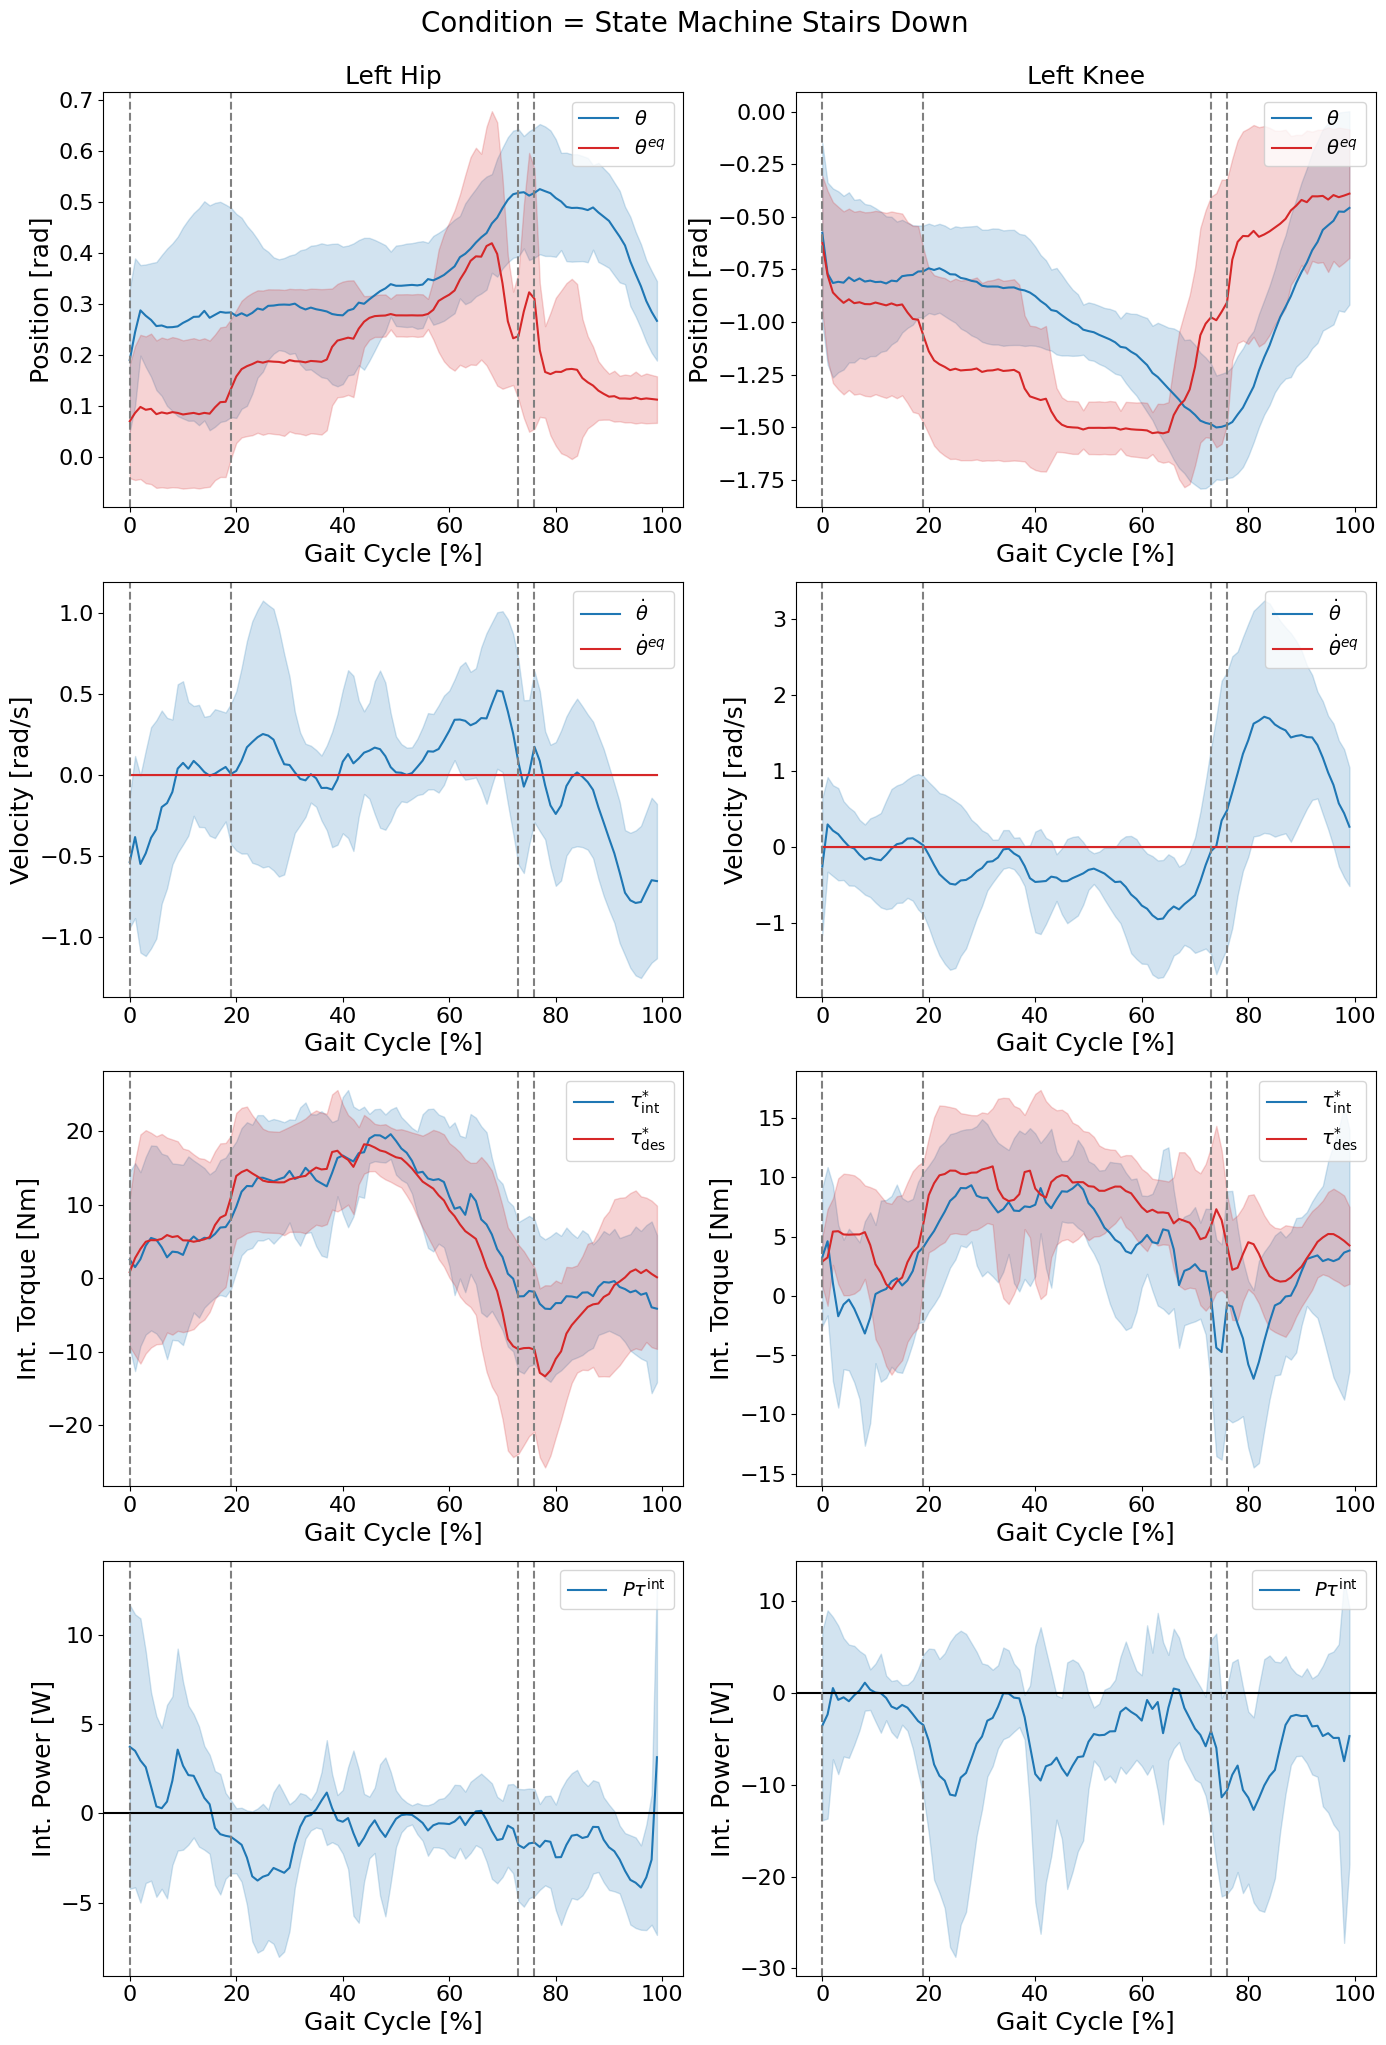

SM_RAMPS_UP


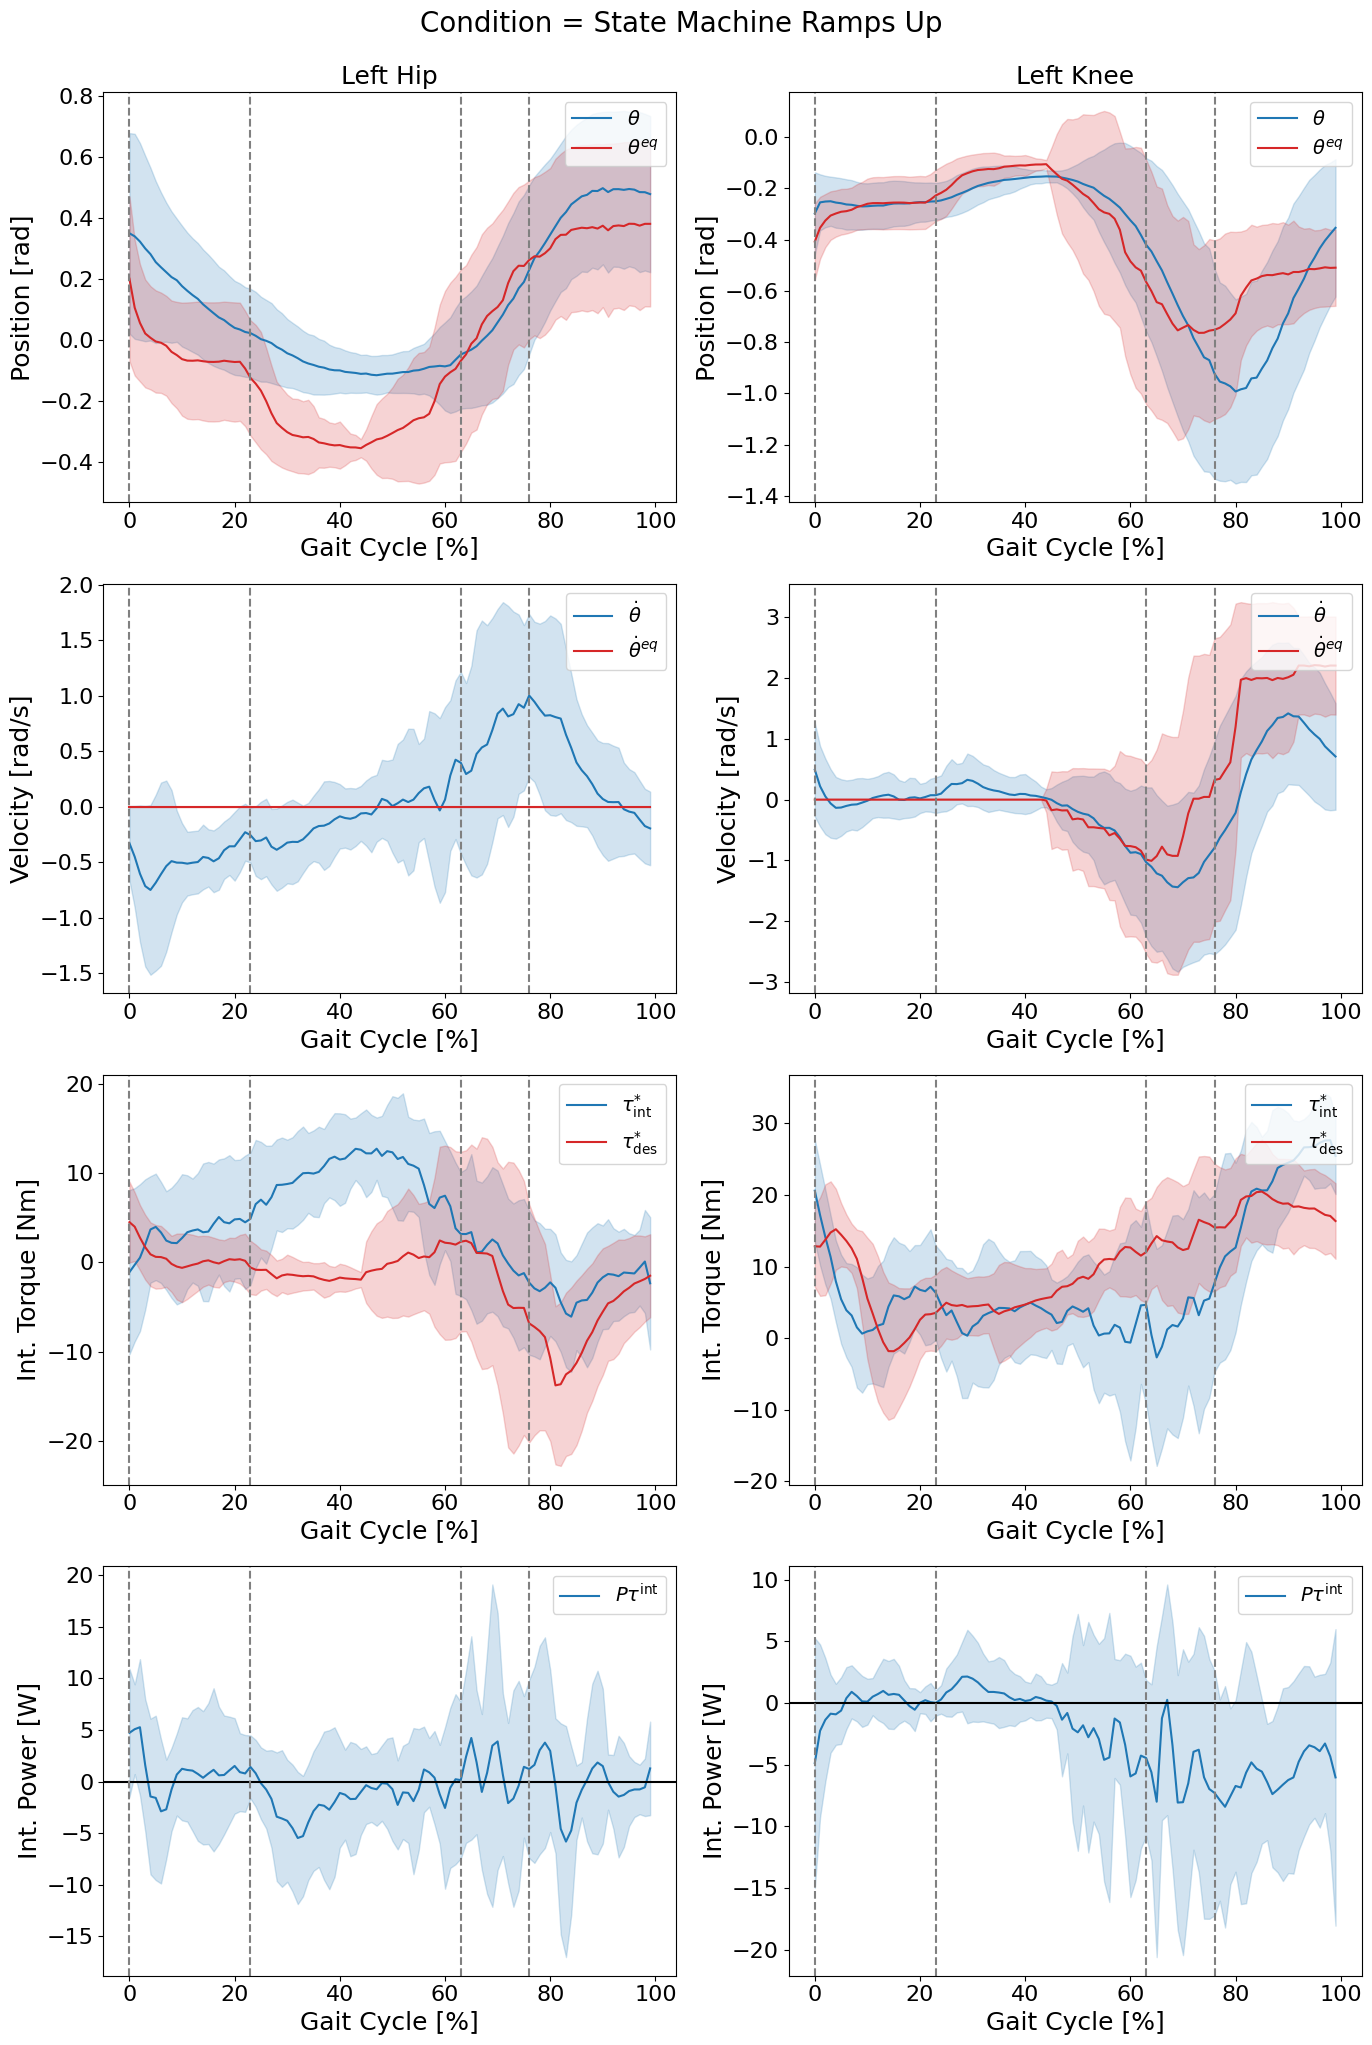

SM_RAMPS_DOWN


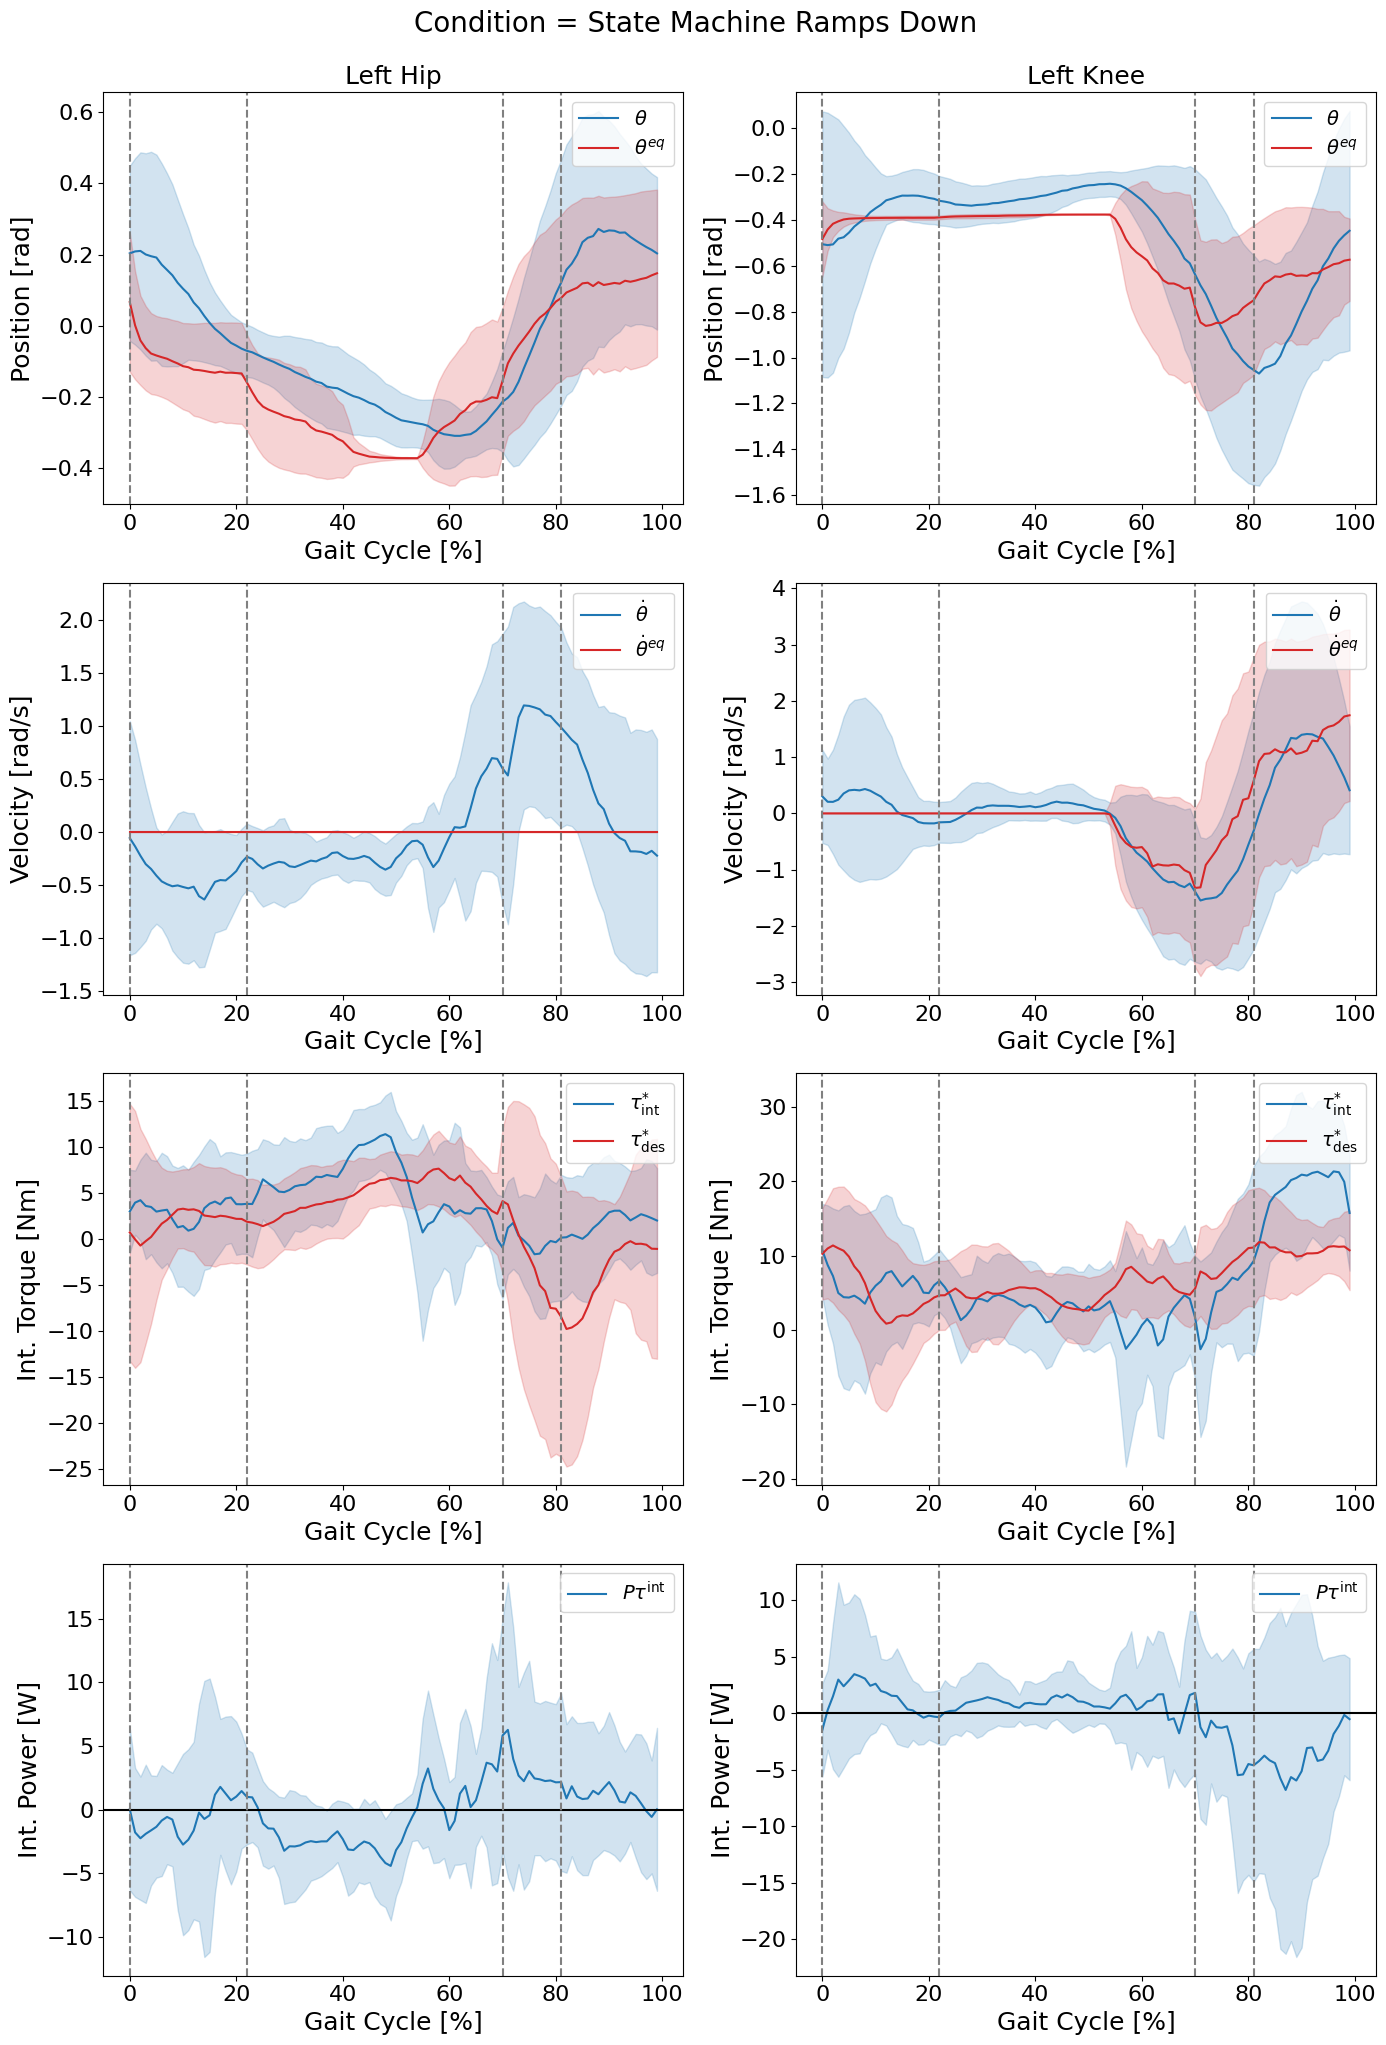

In [8]:
gait_cycle_states = [0.0, 0.33, 0.66, 1.0]

for condition in [c for c in df['condition'].unique() if 'UNDEFINED' not in c and "SM" in c]:
    current_df = df[(df.condition == condition)]

    # Adjust the figure layout to have 4 rows and 2 columns
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(14, 20))

    # Data to plot (excluding the first two gait phase columns), rearranged
    data_to_plot = [
        (" JointPositions_1", " DyadicJointNeutralAngle_1", "Position [rad]", "Left Hip"),
        (" JointPositions_2", " DyadicJointNeutralAngle_2", "Position [rad]", "Left Knee"),
        (" JointVelocities_1", " DyadicTaskStiffness_1", "Velocity [rad/s]", "Left Hip"),
        (" JointVelocities_2", " DyadicTaskStiffness_2", "Velocity [rad/s]", "Left Knee"),
        (" InteractionForces_3", " DesiredInteractionForces_3", "Int. Torque [Nm]", "Left Hip"),
        (" InteractionForces_4", " DesiredInteractionForces_4", "Int. Torque [Nm]", "Left Knee"),
        ("NetPower_1", None, "Int. Power [W]", "Left Hip"),
        ("NetPower_2", None, "Int. Power [W]", "Left Knee")
    ]


    grouped_df = current_df.groupby("gait_cycle_left")[" AnklePositionActual_1"].median()/3
    # Reset the index to 'gait_cycle_left_median'
    grouped_df = grouped_df.reset_index(name='gait_cycle_left_median')

    # Create a new dataframe `df_median`
    df_median = pd.DataFrame({'gait_cycle_left': grouped_df['gait_cycle_left'],
                              'gait_cycle_left_median': grouped_df['gait_cycle_left_median']})

    # Interpolate to find x values where median crosses thresholds - find median gait cycles Early Stance, Late Stance etc.
    x_values = [df_median['gait_cycle_left'][df_median['gait_cycle_left_median'].ge(threshold).idxmax()] for threshold in gait_cycle_states]

    for i, (y_col, y_col2, title, joint_name) in enumerate(data_to_plot):
        row = i // 2   # Calculate row index (integer division by 2)
        col = i % 2    # Calculate column index (modulo 2)

        # Plot the main data
        sns.lineplot(data=current_df, x="gait_cycle_left", y=y_col, errorbar="sd", ax=ax[row, col])

        # Plot the second line if available
        if y_col2:
            sns.lineplot(data=current_df, x="gait_cycle_left", y=y_col2, errorbar="sd", color=sns.color_palette()[3], ax=ax[row, col])

        # Add a horizontal line at y=0 for power plots
        if "Power" in title:
            ax[row, col].axhline(y=0, color="0")

        # Add vertical lines for gait cycle states
        for x_val in x_values:
            ax[row, col].axvline(x=x_val, color='gray', linestyle='--')

        # Add legends
        if "Position" in y_col:
            legend_labels = [r"$\theta$",r"$\theta^{eq}$"]
        elif "Velocities" in y_col:
            legend_labels = [r"$\dot{\theta}$",r"$\dot{\theta}^{eq}$"]
        elif "InteractionForces" in y_col:
            legend_labels = [r"$\tau^{*}_{\mathrm{int}}$",r"$\tau^{*}_{\mathrm{des}}$"]
        else:
            legend_labels = [r"$P\tau^{\mathrm{int}}$"]

        # Get handles and labels, handling the case where there might be no std lines
        handles, _ = ax[row, col].get_legend_handles_labels()
        if len(handles) < len(legend_labels):  # If there are fewer handles than labels
            handles = ax[row, col].lines  # Get all lines in the subplot

        # Pass the handles and labels to the legend function
        ax[row, col].legend(handles[:len(legend_labels)], legend_labels, loc='upper right', fontsize=14)

        # Set labels and title
        ax[row, col].set_ylabel(title, fontsize=18)
        ax[row, col].set_xlabel("Gait Cycle [%]", fontsize=18)

        ax[row, col].tick_params(axis='both', which='major', labelsize=16)

    # Remove the last axis if needed (odd number of plots)
    if len(data_to_plot) % 2 == 1:
        ax[-1, -1].axis('off')

    ax[0, 0].set_title("Left Hip", fontsize=18)
    ax[0, 1].set_title("Left Knee", fontsize=18)
    formatted_activity = helpers.format_activity(condition[3:])

    # Adjust figure layout for better spacing
    fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Experiment with these values

    # Use tight layout to further prevent overlaps
    plt.tight_layout()

    fig.suptitle("Condition = State Machine " + formatted_activity, fontsize=20,  y=1.02)
    print(condition)
    plt.show()